 # Solar wind interaction with Lunar magnetic anomalies

 ## Set up environment and configure setting

In [43]:
import happi
from happi._SmileiSimulation import SmileiSimulation
import numpy as np
import xarray as xr
import pandas as pd
import hvplot.pandas  # noqa: adds hvplot method to pandas objects
import hvplot.xarray  # noqa
import holoviews as hv
from holoviews import opts
from bokeh.resources import INLINE
import matplotlib.pyplot as plt
import matplotlib as mpl
import proplot as pplt
from icecream import ic
from _utils import *

mpl.rcParams['figure.dpi'] = 50
mpl.rcParams['savefig.dpi'] = 50

SPP = SmileiPostProcessing()
SPP.print_simulation()
S = SPP.SmileiSimulation;


timestep: 0.006898434320364854 (code unit)
simulation_time: 1070.6873500000002 (code unit)
number_of_timesteps: 155207
geometry: 2Dcartesian
number_of_cells: [64, 128]
cell_length: [0.009765625, 0.009765625] (code unit)
grid_length: [0.625, 1.25] (code unit)
species solar_electron has mass 1.0  has temperature  [<Quantity 4.275015e+14 eV s2 / (kg m2)>]
species solar_proton has mass 1836.1526734400013  has temperature  [<Quantity 4.275015e+14 eV s2 / (kg m2)>]
An external field By was applied
Fields: ((0,), ('',))
Probes: ([], [])
ParticleBinning: ([], [])
Screen: ([], [])
RadiationSpectrum: ([], [])
Reference time: 0.00043363332375759766 s
timestep: 2.9913910030632957e-06 s
simulation_time: 0.46428571428571436 s
Reference length: 130000.0 m
cell_length: [1269.53125 1269.53125] m
grid_length: [ 81250. 162500.] m


 ### Set metadata

In [44]:
# Set fields metadata: Ex Ey Ez Bx By Bz Bx_m By_m Bz_m Jx Jy Jz Rho Jx_solar_ion Jy_solar_ion Jz_solar_ion Rho_solar_proton Jx_solar_electron Jy_solar_electron Jz_solar_electron Rho_solar_electron

magnetic_field = {}

magnetic_field["yt"] = ["magnetic_field_x", "magnetic_field_y", "magnetic_field_z"]
magnetic_field["smilei"] = ["Bx", "By", "Bz"]
magnetic_field["units"] = ["dimensionless"] * dimensions
B_labels = [r"$B_{x}$", r"$B_{y}$", r"$B_{z}$"]

electric_field = {}
electric_field["yt"] = ["electric_field_x", "electric_field_y", "electric_field_z"]
electric_field["smilei"] = ["Ex", "Ey", "Ez"]
electric_field["units"] = ["dimensionless"] * dimensions
electric_field["labels"] = [r"$E_{x}$", r"$E_{y}$", r"$E_{z}$"]

rho_fields = {}
rho_fields["yt"] = ["Rho_solar_electron", "Rho_solar_proton"]
rho_fields["smilei"] = ["-Rho_solar_electron", "Rho_solar_proton"]
rho_fields["units"] = ["dimensionless"] * 2  # rho_units = ['kg/m**3', 'kg/m**3']
rho_fields["labels"] = [r"$\rho_{solar-electron}$", r"$\rho_{solar-proton}$"]

fields_smilei = [
    *magnetic_field["smilei"],
    *electric_field["smilei"],
    *rho_fields["smilei"],
]
fields_yt = [*magnetic_field["yt"], *electric_field["yt"], *rho_fields["yt"]]
fields_units = [
    *magnetic_field["units"],
    *electric_field["units"],
    *rho_fields["units"],
]


In [45]:
def _reference_quantities_yt():
    from unyt import unyt_quantity

    global L_r_yt, d_i_yt, V_r_yt, T_r_yt
    d_i_yt = unyt_quantity.from_astropy(d_i)

    L_r_yt = unyt_quantity.from_astropy(L_r)
    V_r_yt = unyt_quantity.from_astropy(V_r)
    T_r_yt = unyt_quantity.from_astropy(T_r)
    pass

_reference_quantities_yt()

In [46]:
bbox = [
    [0, grid_length[0]],
    [-grid_length[1] / 2, grid_length[1] / 2],
] * L_r


## Probe Diag

In [47]:
def getFrequency(S: SmileiSimulation, diag=0):
    """Get the frequency of a probe"""
    fields = S.probeInfo(diag)["fields"]
    field = fields[0]
    times = S.Probe(diag, field).getTimes() * T_r
    return 1 / (times[1] - times[0])


In [48]:
def plot_local_probe(
    S: SmileiSimulation,
    location,
    field,
    probeNumber=0,
    happi=False,
    fft=False,
    spectrogram=True,
):
    def _raw_data():
        raw_data = {}
        for field in fields:
            Diag = S.Probe(probeNumber, field, subset={"axis1": location})
            raw_data[field] = np.array(Diag.getData())
        return raw_data

    def _happi():
        Diag = {}
        for field in fields:
            Diag[field] = S.Probe(0, field, subset={"axis1": location}, label=field)
            happi.multiPlot(*Diag.values())

    def _fft():

        def _xr():
            from scipy.fft import fft, fftfreq
            raw_data = _raw_data()
            ds = xr.Dataset()

            for field in fields:
                fft_data = fft(raw_data[field])
                N = fft_data.size
                fft_freq = fftfreq(N, 1 / fs)[: N // 2]

                frequency = xr.DataArray(
                    fft_freq, dims=["Frequency"], attrs={"units": "Hz"}
                )
                ds[field] = xr.DataArray(
                    np.abs(fft_data[: N // 2]), name=field, coords=[frequency],attrs={"long_name": field, "units": ""},
                )

            ds["magnitude"] = np.sqrt(sum([np.square(ds[field]) for field in fields]))
            return ds

        def _pplt():
            fig, axs = pplt.subplots(ncols=len(fields), suptitle="FFT of Field Component")
            for index, field in enumerate(fields):
                axs[index].plot(ds[field])

            fig, axs = pplt.subplots(suptitle="FFT of Field Magnitude")
            axs.plot(ds["magnitude"])
            return fig 

        ds = _xr()

        return _pplt()

    def _spectrogram():

        def _xr():
            from scipy import signal

            def _spec(raw_data, fs, name):
                """Compute a spectrogram with consecutive Fourier transforms"""
                f, t, Sxx = signal.spectrogram(raw_data, fs)
                time = xr.DataArray(t, dims=["Time"], attrs={"units": "s"})
                frequency = xr.DataArray(f, dims=["Frequency"], attrs={"units": "Hz"})
                return xr.DataArray(
                    Sxx,
                    name=name,
                    coords=[frequency, time],
                    attrs={"long_name": name, "units": ""},
                )

            ds = xr.Dataset()
            raw_data = _raw_data()
            for field in fields:
                ds[field] = _spec(raw_data[field], fs, field)
            ds["magnitude"] = np.sqrt(sum([np.square(ds[field]) for field in fields]))
            return ds

        def _pplt():
            ds = _xr()
            fig, axs = pplt.subplots(ncols=len(fields), suptitle="Spectrogram")
            for index, field in enumerate(fields):
                axs[index].contourf(ds[field], N=200, colorbar="t")
            fig, axs = pplt.subplots(suptitle="Spectrogram")
            axs.contourf(ds["magnitude"], N=200, colorbar="r")
            return fig
            # fig.save(prefix + "spectrogram_" + postfix)

        def _hvplot():
            from bokeh.resources import INLINE

            ds = _xr()
            f = {}
            opts.defaults(opts.Image(colorbar=False))
            for index, field in enumerate(fields):
                f[field] = ds[field].hvplot()
                f[field].opts(title=field)
                if index != 0:
                    f[field].opts(yaxis="bare")
            layout = hv.Layout(list(f.values()))
            hvplot.save(layout, prefix + "B/spectrogram.html", resources=INLINE)
            return layout

        def _plt():
            from scipy import signal

            for field in fields:
                Diag = S.Probe(probeNumber, field, subset={"axis1": location}, label=field)
                data = np.array(Diag.getData())
                f, t, Sxx = signal.spectrogram(data, fs)
                ic(f.shape, t.shape, Sxx.shape)
                plt.figure(tight_layout=True)
                plt.pcolormesh(t, f, Sxx, shading="gouraud")
            return
        
        return _pplt()


    if field == "electric":
        fields = electric_field["smilei"]
        mag_name = "E"
    elif field == "magnetic":
        fields = magnetic_field["smilei"]
        mag_name = "B"

    prefix = "figures/"
    fs = getFrequency(S).value

    if fft:
        _fft()
    if happi:
        _happi()
    if spectrogram:
        _spectrogram()


 ## Fields Diag

 ### Plot 2-D species density profiles

 Two-dimensional (top) electron and (bottom) ion charge density profiles, scaled to the initial density, $n_{sw}$ ,and along the dipole axis (Y direction) at z = 0 after the simulation has reached quasi-steady state. The solar wind is flowing perpendicular (in the −X direction) to the lunar surface. Superimposed in black are magnetic field lines.

In [49]:
def plot_density_profile_2D(plot_happi = True):
    def _plot_happi():
        def rho_transform(rho):
            return (rho * N_r / n_solar).si

        # subset
        Rho_solar_electron_z0 = S.Field(
            0,
            "-Rho_solar_electron",
            data_transform=rho_transform,
            title=r"$\rho_{solar-electron}$",
        )
        Rho_solar_ion_z0 = S.Field(
            0,
            "Rho_solar_proton",
            data_transform=rho_transform,
            title=r"$\rho_{solar-proton}$",
        )
        happi.multiPlot(
            Rho_solar_electron_z0,
            Rho_solar_ion_z0,
            shape=[1, 2],
            saveAs="figures/rho/rho_2D_",
        )

    if plot_happi: _plot_happi()


 ### Plot 1-D species density profiles
 Profiles along the direction parallel to the solar wind flow and through the center of the dipole. The upper panel presents the density profiles, normalized to the initial density $n_{sw}$. The remaining panels hold the magnetic and kinetic pressure profiles for the electron (middle) and ion (bottom) populations, in code units.

In [50]:
def plot_density_profile_1D(diag=0, timesteps=None, plot_happi =True):
    if timesteps == None:
        fields = S.fieldInfo(diag)["fields"]
        field = fields[0]
        timesteps = S.Field(diag, field).getTimesteps()
        timesteps = [timesteps[0], timesteps[-1]]
    def _plot_happi():
        def rho_transform(rho):
            return (rho * N_r / n_solar).si

        data = {}
        for field, label in zip(rho_fields["smilei"], rho_fields["labels"]):
            data[field] = S.Field(
                diag,
                field,
                timesteps=timesteps,
                label=label,
                subset={"y": grid_length[1] / 2},
                data_transform=rho_transform,
                xlabel=r"Distance above the surface ($d_i$)",
                # xmin=grid_length[0],
                # xmax=0,
                ylabel=r"$\rho$",
            )
        return happi.multiPlot(
            *[data[field] for field in rho_fields["smilei"]],
            saveAs="figures/rho/rho_sub_1D_"
        )
    
    if plot_happi:
        _plot_happi()


 ### Plot electromagnetic field

In [51]:
def plot_field(
    diag=0, field="electric", dimensions=dimensions, fname=None, plot_happi=False
):

    fields = {}
    shape=[2, 2]
    if dimensions == 1:
        subset = {"y": grid_length[1] / 2}
        _fname_postfix = "_1D"
    else:
        # subset = {"x": [5*cell_length[0],grid_length[0]-5*cell_length[0]]}
        subset = None
        _fname_postfix = "_2D"

    if field == "electric":
        fields["magnitude"] = S.Field(
            diag, "(Ex**2+Ey**2+Ez**2)**0.5", subset=subset
        )
        fields["Ex"] = S.Field(diag, "Ex", subset=subset)
        fields["Ey"] = S.Field(diag, "Ey", subset=subset)
        fields["Ez"] = S.Field(diag, "Ez", subset=subset)
        fname = "figures/E" + _fname_postfix
    elif field == "magnetic":

        def data_transform(data):
            return data / B_IMF_norm.si

        fields["magnitude"] = S.Field(
            diag, "(Bx**2+By**2+Bz**2)**0.5", subset=subset, data_transform=data_transform
        )
        fields["Bx"] = S.Field(
            diag, "Bx", subset=subset, data_transform=data_transform
        )
        fields["By"] = S.Field(
            diag, "By", subset=subset, data_transform=data_transform
        )
        fields["Bz"] = S.Field(
            diag, "Bz", subset=subset, data_transform=data_transform
        )
        fname = "figures/B" + _fname_postfix
    elif field == "density":

        def data_transform(rho):
            return rho / n_solar_norm.si

        for species in S.namelist.Species:
            field = "Rho_" + species.name
            fields[species.name] = S.Field(
                diag, field, subset=subset, data_transform=data_transform
            )
        
        shape = [1,2]
        fname = "figures/rho" + _fname_postfix
        # plot_happi = True

    def _happi():
        plt.figure(figsize=(12, 12), tight_layout=True)
        happi.multiPlot(
            *fields.values(),
            shape=shape,
            saveAs=fname,
        )

    def _xr():
        
        field = next(iter(fields))

        ds = xr.Dataset()
        ds.coords["x"] = fields[field].getAxis("x")
        ds.coords["timestep"] = fields[field].getTimesteps()

        if dimensions == 1:
            dims = ("timestep", "x")
        elif dimensions == 2:
            dims = ("timestep", "x", "y")
            ds.coords["y"] = fields[field].getAxis("y")
        
        for attribute, Diag in fields.items():
            ds[attribute] = (dims, Diag.getData())
        return ds

    def _layout(ds):
        if dimensions == 1:
            f = [ds[attribute].hvplot(x="x",title = attribute) for attribute in ds.keys()]
        elif dimensions == 2:
            f = [ds[attribute].hvplot(x="x", y="y",title = attribute) for attribute in ds.keys()]
        layout = hv.Layout(f)
        layout.cols(2)
        hvplot.save(layout, fname + ".html", resources=INLINE)
        return layout

    if plot_happi:
        _happi()
    else:
        return _layout(_xr())


## TrackParticles Diag

In [52]:
def TrackParticle(num=5):
    def _df(species, sample=True):
        if sample:
            import random

            _Diag = S.TrackParticles(
                species=species.name,
                axes=["Id"],
            )
            _ids = tuple(np.unique(_Diag.getData()["Id"]))
            k = min(num,len(_ids))
            _select = random.sample(_ids, k=k)
        else:
            _select = ""

        Diag = S.TrackParticles(species=species.name, select=_select)
        timesteps = Diag.getTimesteps()
        data = Diag.getData()

        def _timestep_df(index, timestep):
            _data = {attribute: data[attribute][index] for attribute in data.keys()}
            return pd.DataFrame(_data)

        frames = [
            _timestep_df(index, timestep) for index, timestep in enumerate(timesteps)
        ]
        return pd.concat(frames)

    def _hvplot():
        f = {}
        for species in S.namelist.Species:
            df = _df(species)
            hover_cols = df.columns.values.tolist()
            f[species.name] = df.hvplot.points(x="x", y="y", by=["Id"],alpha=0.5,size=1,hover_cols ='all')
            f[species.name].opts(title=species.name)
        layout = hv.Layout(list(f.values()))
        hvplot.save(layout, "figures/track.html", resources=INLINE)
        return layout

    return _hvplot()

### Plot plasma beta

In [53]:
def plot_beta_1D(timestep):
    """
    Plot the
    """
    import astropy.units as u
    from plasmapy.formulary import beta
    T = u.K
    n = u.m**-3
    B = u.T
    beta(T, n, B)
    pass


 ### Plot gyroradius

In [54]:
def plot_gyroradii_1D(timestep):
    from plasmapy.formulary import gyroradius
    pxx = S.ParticleBinning("pxx", sum={"x": "all", "y": "all"})
    pyy = S.ParticleBinning("pyy", sum={"x": "all", "y": "all"})
    v_perp = 0.0
    m = 0.0
    q = 0.0
    B = 0.0

    r_g_solar_electron = gyroradius(B, electron, v_perp)
    r_g_solar_ion = gyroradius(B, ion, v_perp)
    pass


### Plot velocity distribution

In [55]:
def plot_electric_drift_1D(timestep):
    pass


def plot_magnetic_drift_1D(timestep):
    pass


## ParticleBinning Diag

### Plot particle distribution

In [56]:
def plot_particle_distribution_vx_vy_vz_happi(diag_name, timestep=0, center=0):
    """use `happi` to visualize particle distribution
    >>> plot_particle_distribution_vx_vy_vz_happi()
    """
    Nt = S.ParticleBinning(0).getTimesteps()[-1]  # the last timestep

    f_initial = S.ParticleBinning(
        diag_name,
        # data_log=True,
        timesteps=0,
        label="initial",
        sum={"x": "all", "y": "all", "z": "all"},
    )
    f_final = S.ParticleBinning(
        diag_name,
        # data_log=True,
        timesteps=Nt,
        label="final",
        sum={"x": "all", "y": "all", "z": "all"},
    )
    return happi.multiPlot(f_initial, f_final, saveAs="figures/rho/" + diag_name)


def plot_particle_distribution_x_vx_vy_vz_happi(diag_name,timestep=None):
    """use `happi` to visualize particle distribution
    >>> plot_particle_distribution_x_vx_vy_vz_happi()
    """
    Nt = S.ParticleBinning(0).getTimesteps()[-1]  # the last timestep
    f_initial = S.ParticleBinning(
        diag_name,
        # data_log=True,
        timesteps=0,
        label="initial",
        sum={"y": "all", "z": "all"},
    )
    f_final = S.ParticleBinning(
        diag_name,
        # data_log=True,
        timesteps=Nt,
        label="final",
        sum={"y": "all", "z": "all"},
    )
    return happi.multiPlot(
        f_initial, f_final, shape=[1, 2], saveAs="figures/rho/x_" + diag_name
    )

In [57]:
def plot_particle_distribution_vx_vy_vz_bokeh(path="figures/",layout=True,gridspace=False):
    """
    >>>plot_particle_distribution_vx_vy_vz_bokeh()
    """
    from bokeh.resources import INLINE

    def _xr():
        ds = xr.Dataset()
        ds.coords["x"] = S.ParticleBinning(0, sum={"y": "all", "z": "all"}).getAxis("x")
        ds.coords["timestep"] = S.ParticleBinning(
            0, sum={"y": "all", "z": "all"}
        ).getTimesteps()

        for species in solar_species:
            velocity_list = ["vx", "vy", "vz"]
            for velocity in velocity_list:
                name = species.name + "_" + velocity
                ds.coords[name] = S.ParticleBinning(
                    name, sum={"y": "all", "z": "all"}
                ).getAxis(velocity)
                ds[name + "_distribution"] = (
                    ("timestep", "x", name),
                    S.ParticleBinning(name, sum={"y": "all", "z": "all"}).getData(),
                )
        return ds

    def _layout(ds):
        opts.defaults(opts.Image(invert_xaxis=True, xaxis="bare"))
        f1 = ds["solar_electron_vx_distribution"].hvplot(x="x", y="solar_electron_vx")
        f2 = ds["solar_proton_vx_distribution"].hvplot(x="x", y="solar_proton_vx")
        f3 = ds["solar_electron_vy_distribution"].hvplot(x="x", y="solar_electron_vy")
        f4 = ds["solar_proton_vy_distribution"].hvplot(x="x", y="solar_proton_vy")
        f5 = ds["solar_electron_vz_distribution"].hvplot(x="x", y="solar_electron_vz")
        f6 = ds["solar_proton_vz_distribution"].hvplot(x="x", y="solar_proton_vz")

        f1.opts(colorbar_position="top")
        f2.opts(yaxis="right", colorbar_position="top")
        f3.opts(colorbar=False)
        f4.opts(yaxis="right", colorbar=False)
        f5.opts(colorbar=False, xaxis="bottom")
        f6.opts(yaxis="right", colorbar=False, xaxis="bottom")
        layout = f1 + f2 + f3 + f4 + f5 + f6
        layout.cols(2)
        hvplot.save(
            layout, path + "particle_distribution_layout", fmt="html", resources=INLINE
        )
        return layout

    def _gridspace(ds):
        species = ["solar_electron", "solar_proton"]
        velocities = ["vz", "vy", "vx"]

        def particle_distribution(species, velocity):
            name = species + "_" + velocity
            return ds[name + "_distribution"].hvplot(
                x="x", y=name, flip_xaxis=True, colorbar=False
            )

        dict_2D = {
            (p, f): particle_distribution(p, f) for p in species for f in velocities
        }

        gridspace = hv.GridSpace(dict_2D, kdims=["species", "velocities"])

        hvplot.save(
            gridspace,
            path + "particle_distribution_gridspace",
            fmt="html",
            resources=INLINE,
        )
        return gridspace

    ds = _xr()
    result = []
    if layout: result.append(_layout(ds))
    if gridspace: result.append(_gridspace)
    return result


### Plot Temperature

In [58]:
def plot_temp(timesteps=None):
    if timesteps == None:
        # fields = S.fieldInfo(diag)["fields"]
        # field = fields[0]
        # timesteps = S.Field(diag, field).getTimesteps()
        # timesteps = [timesteps[0], timesteps[-1]]
        pass

    temp = ["T_xx","T_yy","T_zz"]
    
    def _xr():
        ds = xr.Dataset()
        for species in solar_species:
            diag_w = species.name + "_weight"
            weight = S.ParticleBinning(diag_w, sum={"y": "all"})
            timesteps = weight.getTimesteps()
            location = weight.getAxis("x")
            coords = [("Timestep",timesteps),("Distance above the surface",location)]
            ds[diag_w] = xr.DataArray(weight.getData(),coords=coords)
            
            for _pressure, _temp in zip(["weight_vx_px", "weight_vy_py", "weight_vz_pz"],temp):
                diag_p = species.name + "_" + _pressure
                diag_t = species.name + "_" + _temp
                pressure = S.ParticleBinning(diag_w, sum={"y": "all"})
                ds[diag_p] = xr.DataArray(pressure.getData(),coords=coords)
                ds[diag_t]  = ds[diag_p]/ds[diag_w]
        return ds
    
    def _hvplot():
        from bokeh.resources import INLINE
        ds = _xr()
        for species in solar_species:
            for _temp in temp:
                diag_t = species.name + "_" + _temp
                f = ds[diag_t][-1,:].hvplot(x="Distance above the surface",y=diag_t)
            hvplot.save(f,diag_t,fmt="html",resources=INLINE)

    def _happi():
        for species in solar_species:
            diag_w = species.name + "_weight"
            weight = S.ParticleBinning(diag_w, sum={"y": "all"})
            data = weight.getData(timestep=timestep)
            p = {}
            for weight in ["weight_vx_px", "weight_vy_py", "weight_vz_pz"]:

                diag_p = species.name + "_" + weight
                p[weight] = S.ParticleBinning(
                    diag_p, sum={"y": "all"}, timesteps=timestep
                )
            happi.multiPlot(*p.values())
    pass

 ## Visualize the tracked macro-particles

 ## Job

timestep: 0.006898434320364854 (code unit)
simulation_time: 1070.6873500000002 (code unit)
number_of_timesteps: 155207
geometry: 2Dcartesian
number_of_cells: [64, 128]
cell_length: [0.009765625, 0.009765625] (code unit)
grid_length: [0.625, 1.25] (code unit)
species solar_electron has mass 1.0  has temperature  [<Quantity 4.275015e+14 eV s2 / (kg m2)>]
species solar_proton has mass 1836.1526734400013  has temperature  [<Quantity 4.275015e+14 eV s2 / (kg m2)>]
An external field By was applied
Fields: ((0,), ('',))
Probes: ([], [])
ParticleBinning: ([], [])
Screen: ([], [])
RadiationSpectrum: ([], [])
Reference time: 0.00043363332375759766 s
timestep: 2.9913910030632957e-06 s
simulation_time: 0.46428571428571436 s
Reference length: 130000.0 m
cell_length: [1269.53125 1269.53125] m
grid_length: [ 81250. 162500.] m


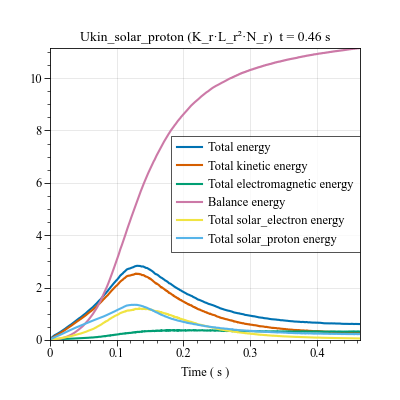

In [59]:
if __name__ == "__main__":
    SPP.print_simulation()
    SPP.plot_scalar()


 ### Fields Diag

In [60]:
# plot_density_profile_1D()
# plot_density_profile_2D()

plot_field(field="electric");
plot_field(field="magnetic");
plot_field(field="density");
# plot_field(field="electric",dimensions=1)
# plot_field(field="magnetic",dimensions=1)


### Probe Diag

In [61]:
# locations = [
    # cell_length[0],
    # grid_length[0] * 1 / 2,
    # grid_length[0] - cell_length[0],
# ]

# for location in locations:
#     fig = plot_local_probe(S, location, field="magnetic")
#     postfix = str(int(location * L_r.value)).zfill(10)
#     fig.save("figures/B/spectrogram_" + postfix)

# for location in locations:
#     fig = plot_local_probe(S, location, field="electric", fft=True,spectrogram=True)
    # postfix = str(int(location * L_r.value)).zfill(10)
    # fig.save("figures/E/spectrogram_" + postfix)


### ParticleBinning Diag

In [62]:
# for species in solar_species:
#     velocity_list = ["vx", "vy", "vz"]
#     for velocity in velocity_list:
#         diag_name = species.name + "_" + velocity
#         plot_particle_distribution_vx_vy_vz_happi(diag_name)
#         # plot_particle_distribution_x_vx_vy_vz_happi(diag_name)

# plot_particle_distribution_vx_vy_vz_bokeh(gridspace=True)

### TrackParticles Diag

In [63]:
# TrackParticle();